## RNN

In [1]:
import tensorflow as tf
import numpy as np
import Utils.Evaluation

In [2]:
from Utils import Pickle

In [3]:
(X_melspec_train, X_melspec_test, X_melspec_valid, y_melspec_train, y_melspec_test, y_melspec_valid) = Pickle.load_pickle('mel_spec.pkl')
(X_mfcc_train, X_mfcc_test, X_mfcc_valid, y_mfcc_train, y_mfcc_test, y_mfcc_valid) = Pickle.load_pickle('mfcc.pkl')
(X_cqt_train, X_cqt_test, X_cqt_valid, y_cqt_train, y_cqt_test, y_cqt_valid) = Pickle.load_pickle('cqt.pkl')

Data\Out\Pickle\mel_spec.pkl
Data\Out\Pickle\mfcc.pkl
Data\Out\Pickle\cqt.pkl


In [4]:
X_train = X_melspec_train.swapaxes(1,2)
X_test = X_melspec_test.swapaxes(1,2)
X_valid = X_melspec_valid.swapaxes(1,2)
X_train.shape, X_test.shape, X_valid.shape # shape = (samples, timesteps, features)

((171566, 2, 200), (57200, 2, 200), (57200, 2, 200))

In [108]:
from Utils.Models import Model
import importlib
import Utils.Models.LSTM as LSTM
importlib.reload(Model)
importlib.reload(LSTM)


#model = LSTM.LSTM(X_train[0].shape)
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=100, activation='tanh', return_sequences=True, input_shape = X_train[0].shape))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.LSTM(units=100, activation='tanh', return_sequences=True))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.LSTM(units=100, activation='tanh', return_sequences=False))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(200, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model.add(tf.keras.layers.Dropout(rate=0.1))
model.add(tf.keras.layers.Dense(200, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model.add(tf.keras.layers.Dropout(rate=0.1))
model.add(tf.keras.layers.Dense(88, activation='relu'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')
cp = tf.keras.callbacks.ModelCheckpoint('models/LSTIM.h5', monitor='val_loss',
                         save_best_only=True, save_weights_only=False,
                         mode='auto', save_freq='epoch', verbose=3)
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 2, 100)            120400    
_________________________________________________________________
dropout_48 (Dropout)         (None, 2, 100)            0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 2, 100)            80400     
_________________________________________________________________
dropout_49 (Dropout)         (None, 2, 100)            0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_50 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 200)             

In [109]:
model.fit(X_train,y_melspec_train,epochs=500,batch_size = 800, validation_data=(X_test,y_melspec_test),callbacks=[cp,early_stopping])
 
'''Model.train(X_train,
            y_melspec_train[:800],
            X_test,
            y_melspec_test[:800],
            batch_size=800,
            n_classes=88,
            model_type='LSTM',
            sr=None,
            max_freq=None,
            shape=X_train[0].shape)'''

Epoch 1/500
215/215 [==============================] - ETA: 0s - loss: 0.1497 - accuracy: 0.0173
Epoch 00001: val_loss improved from inf to 0.13442, saving model to models\LSTIM.h5
215/215 [==============================] - 20s 92ms/step - loss: 0.1497 - accuracy: 0.0173 - val_loss: 0.1344 - val_accuracy: 0.0240
Epoch 2/500
214/215 [============================>.] - ETA: 0s - loss: 0.1277 - accuracy: 0.0200
Epoch 00002: val_loss improved from 0.13442 to 0.12898, saving model to models\LSTIM.h5
215/215 [==============================] - 17s 80ms/step - loss: 0.1277 - accuracy: 0.0200 - val_loss: 0.1290 - val_accuracy: 0.0207
Epoch 3/500
214/215 [============================>.] - ETA: 0s - loss: 0.1248 - accuracy: 0.0225
Epoch 00003: val_loss improved from 0.12898 to 0.12798, saving model to models\LSTIM.h5
215/215 [==============================] - 17s 80ms/step - loss: 0.1248 - accuracy: 0.0225 - val_loss: 0.1280 - val_accuracy: 0.0244
Epoch 4/500
214/215 [============================>

"Train.train(X_train,\n            y_melspec_train[:800],\n            X_test,\n            y_melspec_test[:800],\n            batch_size=800,\n            n_classes=88,\n            model_type='LSTM',\n            sr=None,\n            max_freq=None,\n            shape=X_train[0].shape)"

In [110]:
pred = model(X_valid[:10000])

In [111]:
Utils.Evaluation.get_confusion_matrix(pred, y_melspec_valid[:10000], threshold=0.3)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[850306,  28694],
       [   504,    496]])>

Area under curve: 0.8620057540113549


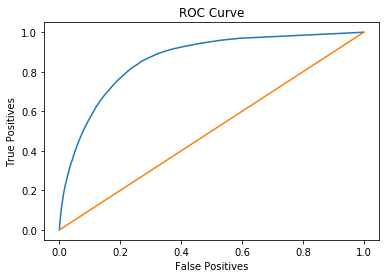

In [112]:
Utils.Evaluation.plot_roc_curve(pred, y_melspec_valid[:10000])

In [ ]:
#print("accuracy", Utils.Evaluation.get_metric(pred, y_melspec_valid[:10000], 'accuracy'))
#print("precision", Utils.Evaluation.get_metric(pred, y_melspec_valid[:10000], 'precision'))
#print("recall", Utils.Evaluation.get_metric(pred, y_melspec_valid[:10000], 'recall'))

In [56]:
old_model = tf.keras.models.load_model('models/LSTIM_best.h5')
old_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 2, 200)            320800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 2, 200)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dropout_10 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 200)              

In [98]:
old_pred = old_model(X_valid[:10000])

In [72]:
Utils.Evaluation.get_confusion_matrix(old_pred, y_melspec_valid[:10000], threshold=0.5)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[847862,  24823],
       [  2948,   4367]])>

Area under curve: 0.9068797025573103


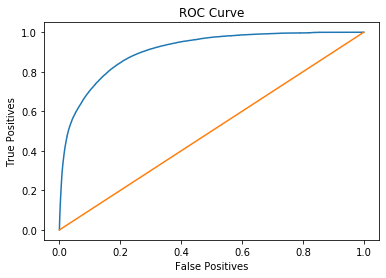

In [76]:
Utils.Evaluation.plot_roc_curve(old_pred, y_melspec_valid[:10000])